In [1]:
import torch

In [2]:
print(torch.cuda.is_available())

True


In [3]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import os
# 定義資料增強和標準化的轉換
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 資料夾路徑
data_dir = r'C:\\Users\\User\\Desktop\\notebook\\plant-seedlings-classification'

# 加載資料
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4)
}

dataset_sizes = {
    'train': len(image_datasets['train'])
}
class_names = image_datasets['train'].classes

# 查看資料加載情況
print(f"Classes: {class_names}")
print(f"Training dataset size: {dataset_sizes['train']}")

from torch.utils.data import random_split



Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
Training dataset size: 4750


In [4]:
# 設定驗證數據集的比例
train_size = int(0.8 * len(image_datasets['train']))
val_size = len(image_datasets['train']) - train_size
train_dataset, val_dataset = random_split(image_datasets['train'], [train_size, val_size])

# 為訓練和驗證數據集創建數據加載器
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': train_size,
    'val': val_size
}


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import ResNet50_Weights  # 導入權重類別

# 加載 ResNet-50 模型並使用預訓練的權重
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)


### 鎖定所有層的權重
for param in model.parameters():
    param.requires_grad = False


# 調整最後一層全連接層的輸出大小以符合您的類別數量
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# 將模型移動到 GPU（如果可用）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 使用交叉熵損失作為損失函數
criterion = nn.CrossEntropyLoss()

# 使用隨機梯度下降（SGD）作為優化器
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

import time
import copy


# def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    
#     # 初始化 lists 來記錄每個 epoch 的損失和準確度
#     train_loss_history = []
#     val_loss_history = []
#     train_acc_history = []
#     val_acc_history = []

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch + 1}/{num_epochs}')
#         print('-' * 10)

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # 設定模型為訓練模式
#             else:
#                 model.eval()   # 設定模型為驗證模式

#             running_loss = 0.0
#             running_corrects = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, labels)

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

#             epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]

#             print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

#             # 記錄損失和準確度
#             if phase == 'train':
#                 train_loss_history.append(epoch_loss)
#                 train_acc_history.append(epoch_acc)
#             else:
#                 val_loss_history.append(epoch_loss)
#                 val_acc_history.append(epoch_acc)

#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best val Acc: {best_acc:.4f}')

#     model.load_state_dict(best_model_wts)
    
#     # 返回模型以及訓練和驗證損失/準確度歷史記錄
#     return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history



In [6]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 設定模型為訓練模式
            else:
                model.eval()   # 設定模型為驗證模式

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 記錄損失和準確度（將 GPU 張量轉換為 CPU 和 NumPy）
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())  # .cpu().numpy() 這裡的更改
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())  # .cpu().numpy() 這裡的更改

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [7]:
# 訓練模型
trained_model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    dataloaders=dataloaders, 
    dataset_sizes=dataset_sizes, 
    device=device, 
    num_epochs=40
)


Epoch 1/40
----------
train Loss: 2.1063 Acc: 0.3155
val Loss: 1.8191 Acc: 0.4558

Epoch 2/40
----------
train Loss: 1.6793 Acc: 0.4971
val Loss: 1.5118 Acc: 0.5389

Epoch 3/40
----------
train Loss: 1.4760 Acc: 0.5658
val Loss: 1.3977 Acc: 0.5821

Epoch 4/40
----------
train Loss: 1.3600 Acc: 0.6029
val Loss: 1.2751 Acc: 0.6295

Epoch 5/40
----------
train Loss: 1.2297 Acc: 0.6392
val Loss: 1.1753 Acc: 0.6547

Epoch 6/40
----------
train Loss: 1.2116 Acc: 0.6392
val Loss: 1.1105 Acc: 0.6863

Epoch 7/40
----------
train Loss: 1.1421 Acc: 0.6626
val Loss: 1.0491 Acc: 0.6958

Epoch 8/40
----------
train Loss: 1.1129 Acc: 0.6668
val Loss: 1.0058 Acc: 0.6905

Epoch 9/40
----------
train Loss: 1.0663 Acc: 0.6747
val Loss: 1.0142 Acc: 0.6853

Epoch 10/40
----------
train Loss: 1.0568 Acc: 0.6884
val Loss: 1.0088 Acc: 0.7011

Epoch 11/40
----------
train Loss: 1.0155 Acc: 0.6895
val Loss: 0.9590 Acc: 0.6947

Epoch 12/40
----------
train Loss: 0.9793 Acc: 0.7076
val Loss: 0.9529 Acc: 0.6989

E

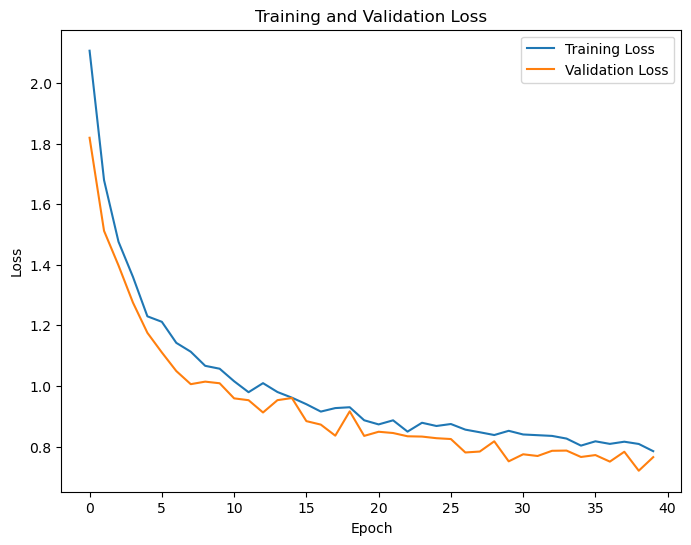

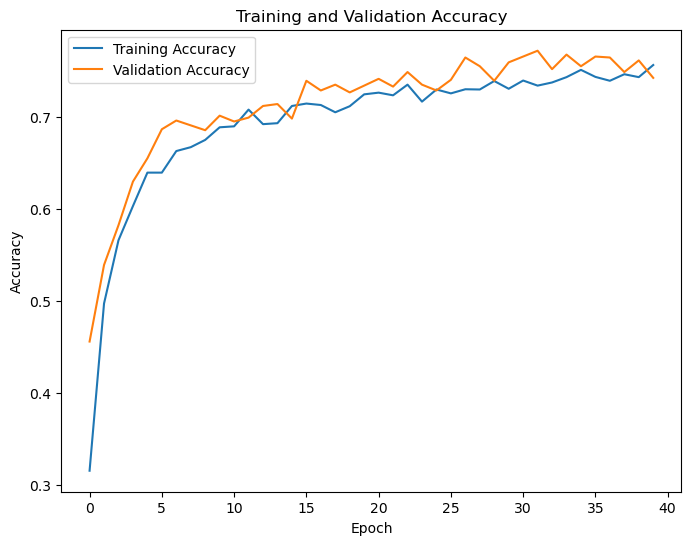

In [8]:
import matplotlib.pyplot as plt

# 繪製訓練和驗證損失曲線
plt.figure(figsize=(8, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 繪製訓練和驗證準確度曲線
plt.figure(figsize=(8, 6))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


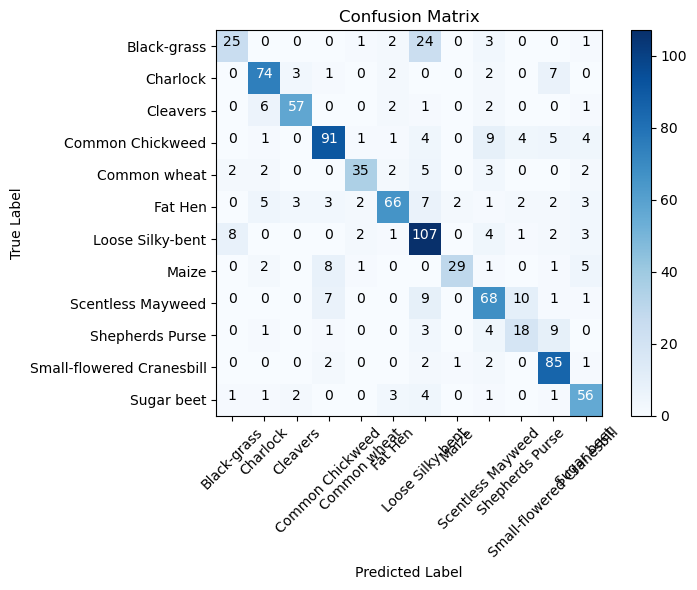

In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

# 進行模型推理以獲取混淆矩陣
all_preds = []
all_labels = []

model.eval()  # 設定模型為驗證模式
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 計算混淆矩陣
cm = confusion_matrix(all_labels, all_preds)

# 繪製混淆矩陣
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # 繪製數值
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names)
plt.show()


預測

In [10]:
import os
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd

# 設置模型到評估模式
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# 定義預處理
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
# 設定測試資料夾的路徑
test_dir = 'C:\\Users\\User\\Desktop\\notebook\\plant-seedlings-classification\\test'  # 替換為你的test資料夾的路徑

# 建立存儲結果的數據框
submission = pd.DataFrame(columns=['file', 'species'])

# 遍歷測試資料夾中的所有圖片文件
for filename in os.listdir(test_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # 這裡假設測試圖片是 .jpg 或 .png 格式
        # 加載圖片並進行預處理
        image_path = os.path.join(test_dir, filename)
        image = Image.open(image_path)
        image = data_transforms(image)
        image = image.unsqueeze(0).to(device)  # 添加批次維度並移動到 GPU（如果可用）

        # 預測圖片類別
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predicted_class = class_names[predicted.item()]

        # 將結果添加到數據框中
        submission = pd.concat([submission, pd.DataFrame({'file': [filename], 'species': [predicted_class]})], ignore_index=True)

# 將結果保存到 CSV 文件中
submission.to_csv('sample_submission.csv', index=False)
